In [2]:
import matplotlib.pyplot as plt
import math as m
from scipy.stats import norm
import numpy as np

In [36]:
def find_Xt_1(t, steps, paths):
    # initialize parameters
    dt = t/steps
    X0 = 1
    Xt = [np.array([X0]*paths)]

    for i in range(steps):
        # remove the current level of Xt, and append the level of Xt next time step
        Xt_current = Xt.pop()
        Xt.append(Xt_current + ((1/5) - (1/2)*Xt_current)*dt + (2/3)*m.sqrt(dt)* np.random.normal(0,1, paths))
        
    return Xt[0]

In [18]:
def find_Yt_1(t, steps, paths):
    # initialize parameters
    dt = t/steps
    Y0 = 3/4
    Yt = [np.array([Y0]*paths)]

    for i in range(1, steps + 1):
        # remove the current level of Yt, and append the level of Yt next time step
        Yt_current = Yt.pop()
        Yt.append(Yt_current + ((2/((i*dt) + 1))* Yt_current + ((i*dt)**3 + 1)/3)*dt 
                    + ((i*dt) **3 + 1)/3 *m.sqrt(dt) * np.random.normal(0, 1, paths))
            
    return Yt[0]

In [33]:
np.random.seed(7)

Y2 = find_Yt_1(2, 2000, 10000)
P = (Y2>5).sum()/10000
P

0.9764

In [52]:
X2 = find_Xt_1(t = 2, steps = 2000, paths = 10000)
X2_transform = list(map(lambda x: np.sign(x)*np.absolute(x)**(1/3), X2))

E = sum(X2_transform)/10000
E

0.6506442931707397

In [54]:
Y3 = find_Yt_1(3, 3000, 10000)

E_Y3 = sum(Y3)/10000
E_Y3

X2 = list(find_Xt_1(2, 2000, 10000))
Y2 = list(find_Yt_1(2, 2000, 10000))

fX2Y2 = list(map(lambda x, y: x*y if x>1 else 0, X2, Y2))
Ef_X2Y2 = sum(fX2Y2)/10000
Ef_X2Y2

3.917765848845672

In [61]:
def find_Xt2(t, steps, paths):
    # initialize parameters
    dt = t/steps
    X0 = 1
    Xt = [np.array([X0]*paths)]

    for i in range(steps):
        # remove the current level of Xt, and append the level of Xt next time step
        Xt_current = Xt.pop()
        Xt.append(Xt_current + ((1/4)*Xt_current) *dt + (1/3)*Xt_current * m.sqrt(dt)* np.random.normal(0, 1, paths) - (3/4)*Xt_current * m.sqrt(dt)* np.random.normal(0, 1, paths))       
    return Xt[0]

In [62]:
def find_Yt2(t,paths):
    Yt = np.exp(-0.08*t + (1/3)* m.sqrt(t)* np.random.normal(0, 1, paths) + (3/4)* m.sqrt(t)* np.random.normal(0, 1, paths))
    return Yt

np.random.seed(7)

fx3 = 1+find_Xt2(3, 3000, 10000)
Efx3 = sum(np.sign(fx3)*np.absolute(fx3)**(1/3))/10000
Efx3
fy3 = 1+find_Yt2(3, 10000)
Efy3 = sum(np.sign(fy3)*np.absolute(fy3)**(1/3))/10000
Efy3

1.337084969916133

## Monte Carlo Simulation for Option Pricing

In [69]:
def euro_call(S0, sd, T, K, r):
    Wt = m.sqrt(T)*np.random.normal(0,1,50000)
    ST = S0*np.exp(sd*Wt + (r-.5*sd**2)*T)
    payoffs = np.array(list(map(lambda st:st-K if st-K>0 else 0, ST)))

    Wt_ = -Wt
    ST_ = S0*np.exp(sd*Wt_ + (r-.5*sd**2)*T)
    payoffs_ = np.array(list(map(lambda st:st-K if st-K>0 else 0, ST_)))

    payoffs = (payoffs + payoffs_)/2
    C = m.exp(-r*T)*sum(payoffs)/len(payoffs)
    return (C)

In [70]:
np.random.seed(9)
T = 5
S0 = 88
r = 0.04
sd = 0.2
K = 100

print(euro_call(S0, sd, T, K, r))



18.257516374911088


In [71]:
def N(x):
    d1 = 0.0498673470
    d2 = 0.0211410061 
    d3 = 0.0032776263
    d4 = 0.0000380036 
    d5 = 0.0000488906 
    d6 = 0.0000053830
    
    if x > 0:
        N = 1 - (1/2)*(1 + d1*x + d2*x**2 + d3*x**3 
                       + d4*x**4 + d5*x**5 + d6*x**6) **(-16) 
    else:
        N =  1 - (1 - (1/2)*(1 + d1*(-x) + d2*(-x)**2 + d3*(-x)**3 
                       + d4*(-x)**4 + d5*(-x)**5 + d6*(-x)**6) **(-16) )

    
    return N

def BlackSholes_call(S0, sd, T, K, r):
    # find d1 and d2
    d1 = (m.log(S0/K) + (r + 0.5*sd**2)*T)/(sd*m.sqrt(T))
    d2 = d1 - sd*m.sqrt(T)

    # find call option price
    C = S0*N(d1) - K*m.exp(-r*T)*N(d2)
    
    return (C)

T = 5
S0 = 88
r = 0.04
sd = 0.2
K = 100

print(BlackSholes_call(S0, sd, T, K, r))

18.283767108827043


## Plot Greeks for Range of Spot

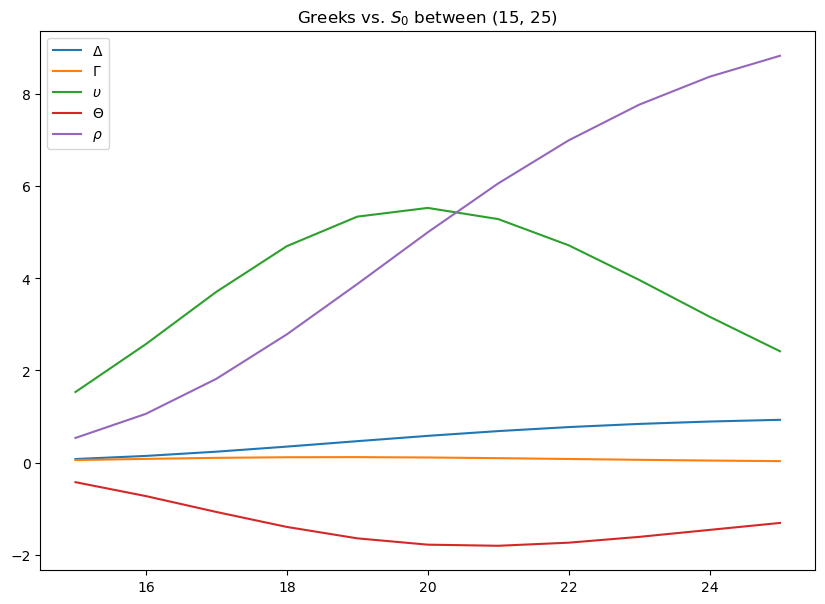

In [75]:
K = 20
sd = 0.25
r = 0.04
T = 0.5
S0_range = list(range(15, 26))

eps = 0.0001
delta = [(BlackSholes_call(S0_range[i] + eps, sd, T, K, r) 
          -  BlackSholes_call(S0_range[i], sd, T, K, r)) / eps
         for i in list(range(len(S0_range)))]

gamma = [(BlackSholes_call(S0_range[i] + eps, sd, T, K, r) 
          -  2* BlackSholes_call(S0_range[i], sd, T, K, r)
         + BlackSholes_call(S0_range[i] - eps, sd, T, K, r))/ (eps)**2
         for i in list(range(len(S0_range)))]
vega = [(BlackSholes_call(S0_range[i], sd + eps, T, K, r) 
          -  BlackSholes_call(S0_range[i], sd, T, K, r)) / eps
         for i in list(range(len(S0_range)))]
theta = [(BlackSholes_call(S0_range[i], sd, T - eps, K, r) 
          -  BlackSholes_call(S0_range[i], sd, T, K, r)) / eps
         for i in list(range(len(S0_range)))]
rho = [(BlackSholes_call(S0_range[i], sd, T, K, r + eps) 
          -  BlackSholes_call(S0_range[i], sd, T, K, r)) / eps
         for i in list(range(len(S0_range)))]
delta = list(zip(S0_range, delta))
gamma = list(zip(S0_range, gamma))
vega = list(zip(S0_range, vega))
theta = list(zip(S0_range, theta))
rho = list(zip(S0_range, rho))

plt.figure(figsize=(10,7))
plt.plot(*zip(*delta), label="$\Delta$")
plt.plot(*zip(*gamma), label = "$\Gamma$")
plt.plot(*zip(*vega), label = "$\\upsilon$")
plt.plot(*zip(*theta), label = "$\Theta$")
plt.plot(*zip(*rho), label = "$\\rho$")
plt.title("Greeks vs. $S_0$ between (15, 25)")
plt.legend()
plt.show()

## Heston Model

In [95]:
def bivariate_normals(paths):
    Z1 = np.random.normal(0,1,paths)
    Z2 = np.random.normal(0,1,paths)
    Z = np.array([Z1, Z2])
    cov = np.array([[1,-0.6],[-0.6, 1]])
    L = np.linalg.cholesky(cov)
    V1, V2 = L.dot(Z)

    return V1, V2

def St_reflection(t, steps, paths, a,b, V0, S0, r, sd):
    dt = t/steps
    Vt = [np.array([V0]*paths)]
    St = [np.array([S0]*paths)]

    for i in range(1, steps + 1):
        dwt1 = np.sqrt(dt)*bivariate_normals(paths)[0]
        dwt2 = np.sqrt(dt)*bivariate_normals(paths)[1]
        Vt_current = Vt.pop()
        St_current = St.pop()
        St.append(St_current + + r*St_current*dt + np.sqrt(abs(Vt_current))*St_current*dwt1)
        Vt.append(abs(Vt_current) + (a* (b - abs(Vt_current)))*dt + sd*np.sqrt(abs(Vt_current))*dwt2)

    return St[0]

In [91]:
def St_full_trunc(t, steps, paths, a, b, V0, S0, r, sd):

    # initialize sequence
    dt = t/steps
    Vt = [np.array([V0]*paths)]
    St = [np.array([S0]*paths)]

    for i in range(1, steps + 1):
        # generate correlated dWt1, dWt2
        dWt1 = np.sqrt(dt)* bivariate_normals(paths)[0]
        dWt2 = np.sqrt(dt)* bivariate_normals(paths)[1]
        # truncate Vt to 0 if < 0
        Vt_current = Vt.pop()
        Vt_current[Vt_current < 0] = 0
        
        St_current = St.pop()
        St.append(St_current + r*St_current*dt 
                                      + np.sqrt(Vt_current)*St_current*dWt1)
        
        Vt.append(Vt_current + (a* (b - Vt_current))*dt 
                  + sd*np.sqrt(Vt_current)*dWt2)
        
    return St[0]

In [92]:
def St_partial_trunc(t, steps, paths, a, b, V0, S0, r, sd):

    # initialize sequence
    dt = t/steps
    Vt = [np.array([V0]*paths)]
    St = [np.array([S0]*paths)]

    for i in range(1, steps + 1):
        # generate correlated dWt1, dWt2
        dWt1 = np.sqrt(dt)* bivariate_normals(paths)[0]
        dWt2 = np.sqrt(dt)* bivariate_normals(paths)[1]
        # truncate Vt to 0 if < 0
        Vt_current = Vt.pop()
        Vt_current_plus = Vt_current.copy()
        Vt_current_plus[Vt_current_plus < 0] = 0

        St_current = St.pop()
        St.append(St_current + r*St_current*dt 
                                      + np.sqrt(Vt_current_plus)*St_current*dWt1)
        
        Vt.append(Vt_current + (a* (b - Vt_current_plus))*dt 
                  + sd*np.sqrt(Vt_current_plus)*dWt2)
        
    return St[0]

In [98]:
def eur_call_heston(t, steps, paths, a,b,V0, S0, r, sd, K):
    st1 =  St_reflection(t, steps, paths, a, b, V0, S0, r, sd)
    st2 = St_full_trunc(t, steps, paths, a, b, V0, S0, r, sd)
    st3 = St_partial_trunc(t, steps, paths, a, b, V0, S0, r, sd)

    payoffs_1 = list(map(lambda st1: st1 - K if (st1 - K)>0 else 0, st1))
    payoffs_2 = list(map(lambda st2: st2 - K if (st2 - K)>0 else 0, st2))
    payoffs_3 = list(map(lambda st3: st3 - K if (st3 - K)>0 else 0, st3))

    C1 = m.exp(-r*t) * sum(payoffs_1)/len(payoffs_1)
    C2 = m.exp(-r*t) * sum(payoffs_2)/len(payoffs_2)
    C3 = m.exp(-r*t) * sum(payoffs_3)/len(payoffs_3)

    return C1, C2, C3
    

In [99]:
np.random.seed(7)
a = 5.8
b = 0.0625

V0 = 0.05
S0 = 48
r = 0.03
sd = 0.42
t = 5
K = 50
steps = 500
paths = 10000

print(eur_call_heston(t, steps, paths, a, b, V0, S0, r, sd, K))

(12.352307146368021, 12.390822562375636, 12.798231167513718)


## Quasi Monte Carlo

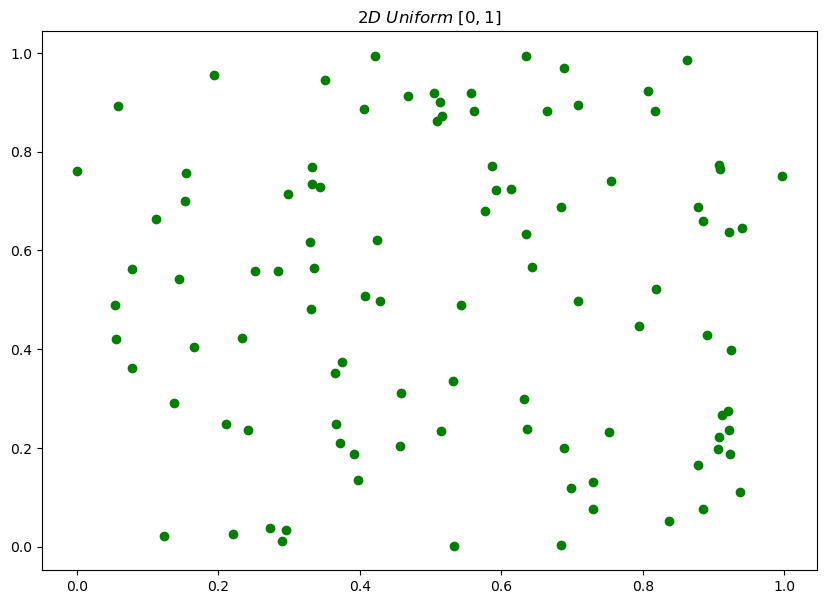

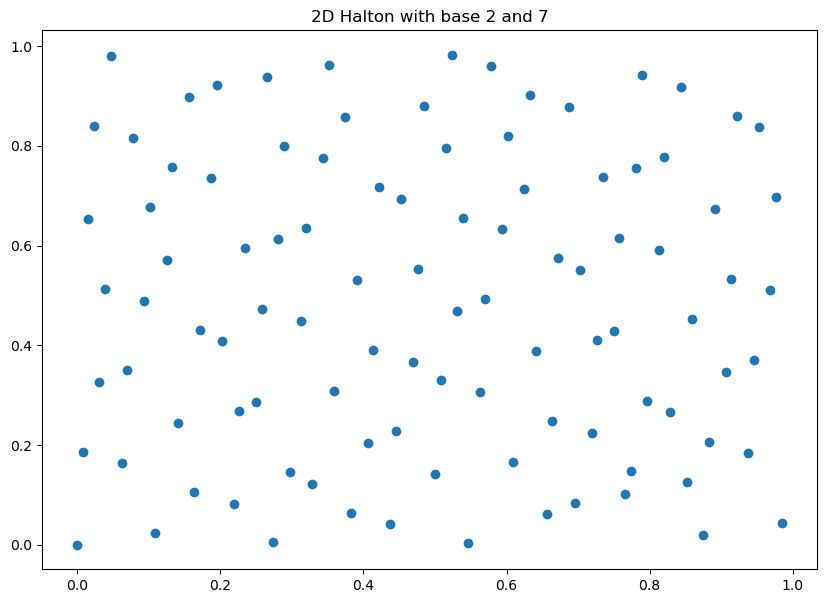

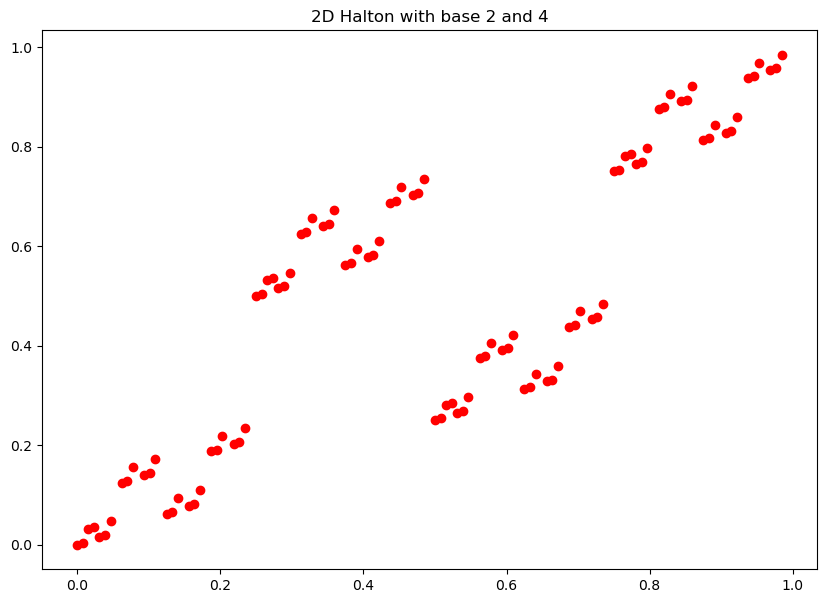

In [100]:
def generate_random_sequence(seed, n):
    
    rand_sequence = [seed]
    for i in range(1, n + 1):
        rand_sequence.append(7**5 * rand_sequence[i-1] % (2**31 - 1))
        
    return rand_sequence[1:]

def generate_2d_uniform(seed, n):

    rand = generate_random_sequence(seed, n * 2)
    
    # construct uniform random samples from the random sequence above
    U1 = list(map(lambda x1: (x1 + 0.5) / (2**31 - 1), rand[:n]))
    U2 = list(map(lambda x2: (x2 + 0.5) / (2**31 - 1), rand[n:]))
    
    #zip U1, U2 to make U 2-D
    U = list(zip(U1, U2))
    
    return U

U = generate_2d_uniform(7, 100)

def Halton_1D(size, base):
    sequence = []
    for i in range(size):
        k, m = 0., 1.
        while i > 0:
            i, a = (i // base, i % base)
            m *= base
            k += a / m
        sequence.append(k)

    return sequence
def Halton_2D(size, m1, m2):
    
    halton_x = Halton_1D(size, m1)
    halton_y = Halton_1D(size, m2)
    
    halton_2d = list(zip(halton_x, halton_y))

    return halton_2d

halton_2D_27 = Halton_2D(100, 2, 7)

halton_2D_24 = Halton_2D(100, 2, 4)

plt.figure(figsize=(10,7))
plt.scatter(*zip(*U), c = 'g')
plt.title("$2D\ Uniform\ [0, 1]$")
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(*zip(*halton_2D_27))
plt.title("2D Halton with base 2 and 7")
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(*zip(*halton_2D_24), c = 'r')
plt.title("2D Halton with base 2 and 4")
plt.show()